In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [5]:
DATASET_ID = 'bengalese_finch_sober'

In [6]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [7]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'bf.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/bengalese_finch_sober/bf.pickle')

In [8]:
syllable_df = pd.read_pickle(df_loc)

In [9]:
syllable_df[:3]

start_time  end_time labels      indv  indvi  \
0    1.058250  1.089219      i  gr41rd51      0   
1    2.058187  2.117165      i  gr41rd51      0   
2    2.234500  2.285938      i  gr41rd51      0   

                                                 key   rate  \
0  gr41rd51__3part_SYLc_th4191_belowhits_220612_1...  32000   
1  gr41rd51__3part_SYLc_th4191_belowhits_220612_1...  32000   
2  gr41rd51__3part_SYLc_th4191_belowhits_220612_1...  32000   

                                         spectrogram  
0  [[5, 5, 5, 5, 3, 25, 26, 75, 105, 80, 47, 16, ...  
1  [[4, 4, 4, 4, 16, 8, 6, 11, 7, 3, 3, 14, 51, 2...  
2  [[2, 2, 2, 3, 0, 26, 49, 12, 9, 2, 2, 93, 68, ...

In [10]:
len(syllable_df)

215663

In [11]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### cluster

In [12]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [13]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [14]:
import hdbscan

In [15]:
from avgn.visualization.projections import draw_projection_transitions

In [16]:
from sklearn.decomposition import PCA



gr41rd51 52788


or60yw70 35799


gy6or6 56375


bl26lb16 70701


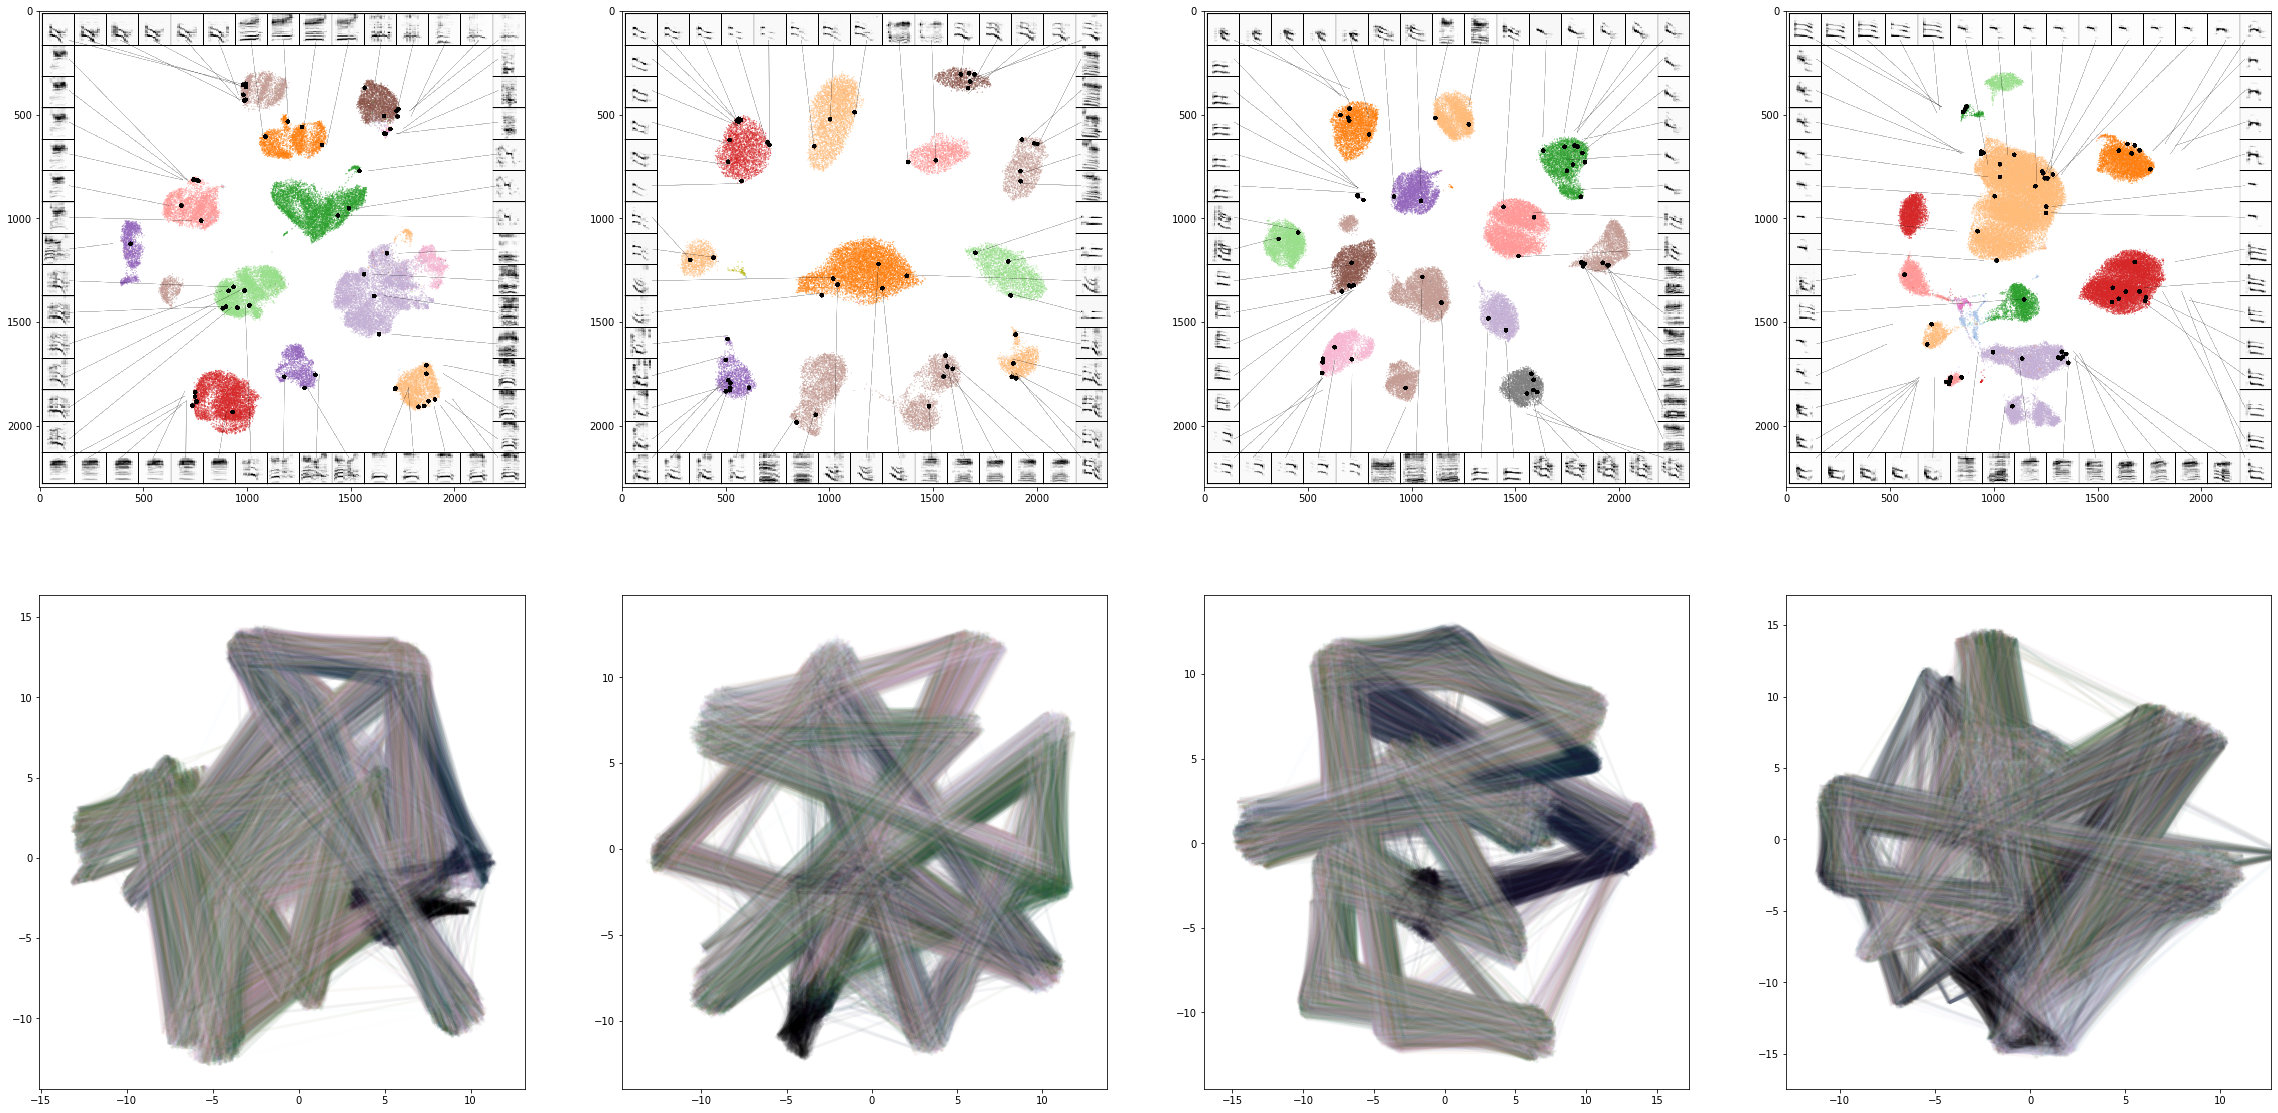

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=len(syllable_df.indv.unique()), figsize=(10*len(syllable_df.indv.unique()), 20))

indv_dfs = {}
for indvi, indv in enumerate(tqdm(syllable_df.indv.unique())):
    #if indv != 'Bird5': continue
    indv_dfs[indv] = syllable_df[syllable_df.indv == indv]
    indv_dfs[indv] = indv_dfs[indv].sort_values(by=["key", "start_time"])
    print(indv, len(indv_dfs[indv]))
    specs = [norm(i) for i in indv_dfs[indv].spectrogram.values]
    
    # sequencing
    indv_dfs[indv]["syllables_sequence_id"] = None
    indv_dfs[indv]["syllables_sequence_pos"] = None
    for ki, key in enumerate(indv_dfs[indv].key.unique()):
        indv_dfs[indv].loc[indv_dfs[indv].key == key, "syllables_sequence_id"] = ki
        indv_dfs[indv].loc[indv_dfs[indv].key == key, "syllables_sequence_pos"] = np.arange(
            np.sum(indv_dfs[indv].key == key)
        )
        
    # umap
    specs_flattened = flatten_spectrograms(specs)
    cuml_umap = cumlUMAP(min_dist=0.5)
    z = list(cuml_umap.fit_transform(specs_flattened))
    indv_dfs[indv]["umap"] = z
    
    pca = PCA(n_components=100)
    z_pca = pca.fit_transform(specs_flattened)
    indv_dfs[indv]["PCA"] = list(z_pca)

    # plot
    scatter_spec(
        np.vstack(z),
        specs,
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': list(indv_dfs[indv].labels.values),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True,
        ax= ax[0,indvi]
    );
    
    draw_projection_transitions(
        projections=np.array(list(indv_dfs[indv]['umap'].values)),
        sequence_ids=indv_dfs[indv]["syllables_sequence_id"],
        sequence_pos=indv_dfs[indv]["syllables_sequence_pos"],
        ax=ax[1,indvi],
    )

    

### label

In [18]:
from sklearn.cluster import MiniBatchKMeans

In [19]:
for indv in tqdm(indv_dfs.keys()):
    ### cluster
    
    z_pca = list(indv_dfs[indv]["PCA"].values)

    ### HDBSCAN on PCA
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=int(len(z) * 0.001), # the smallest size we would expect a cluster to be
        min_samples=1, # larger values = more conservative clustering
    )
    clusterer.fit(z_pca);
    indv_dfs[indv]['hdbscan_labels_PCA'] = clusterer.labels_
    
    #break
    z = list(indv_dfs[indv]["umap"].values)
    # HDBSCAN UMAP
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=int(len(z) * 0.01), # the smallest size we would expect a cluster to be
        min_samples=1, # larger values = more conservative clustering
    )
    clusterer.fit(z);
    indv_dfs[indv]['hdbscan_labels'] = clusterer.labels_
    
    # HDBSCAN 
    specs = [norm(i) for i in indv_dfs[indv].spectrogram.values]
    specs_flattened = flatten_spectrograms(specs)
    
    # kmeans
    # get number of possible states
    n_states = len(indv_dfs[indv].labels.unique())

    kmeans = MiniBatchKMeans(n_clusters = n_states).fit(z)
    indv_dfs[indv]['kmeans_labels'] = kmeans.labels_
    
    # kmeans data
    kmeans = MiniBatchKMeans(n_clusters = n_states).fit(specs_flattened)
    indv_dfs[indv]['kmeans__pix_labels'] = kmeans.labels_

### plot

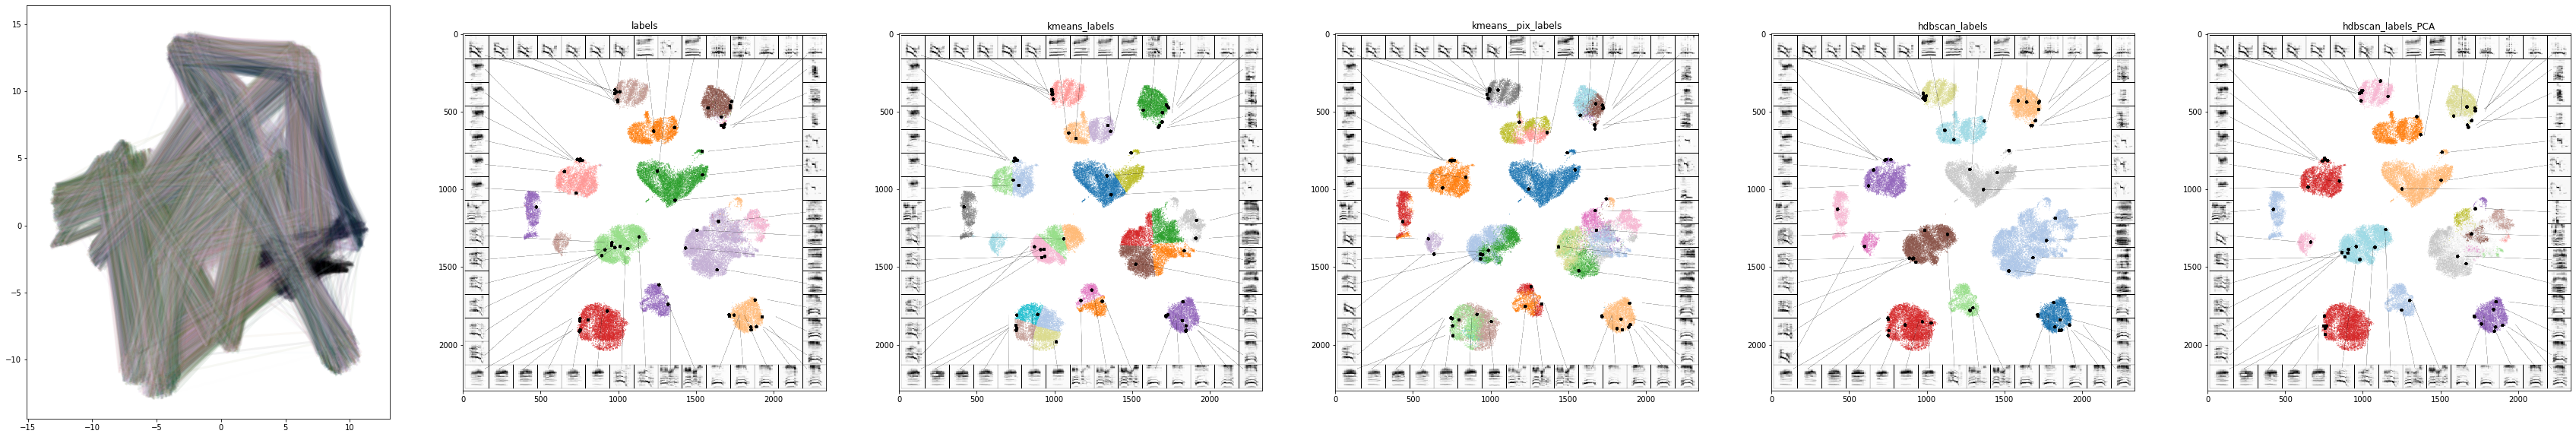

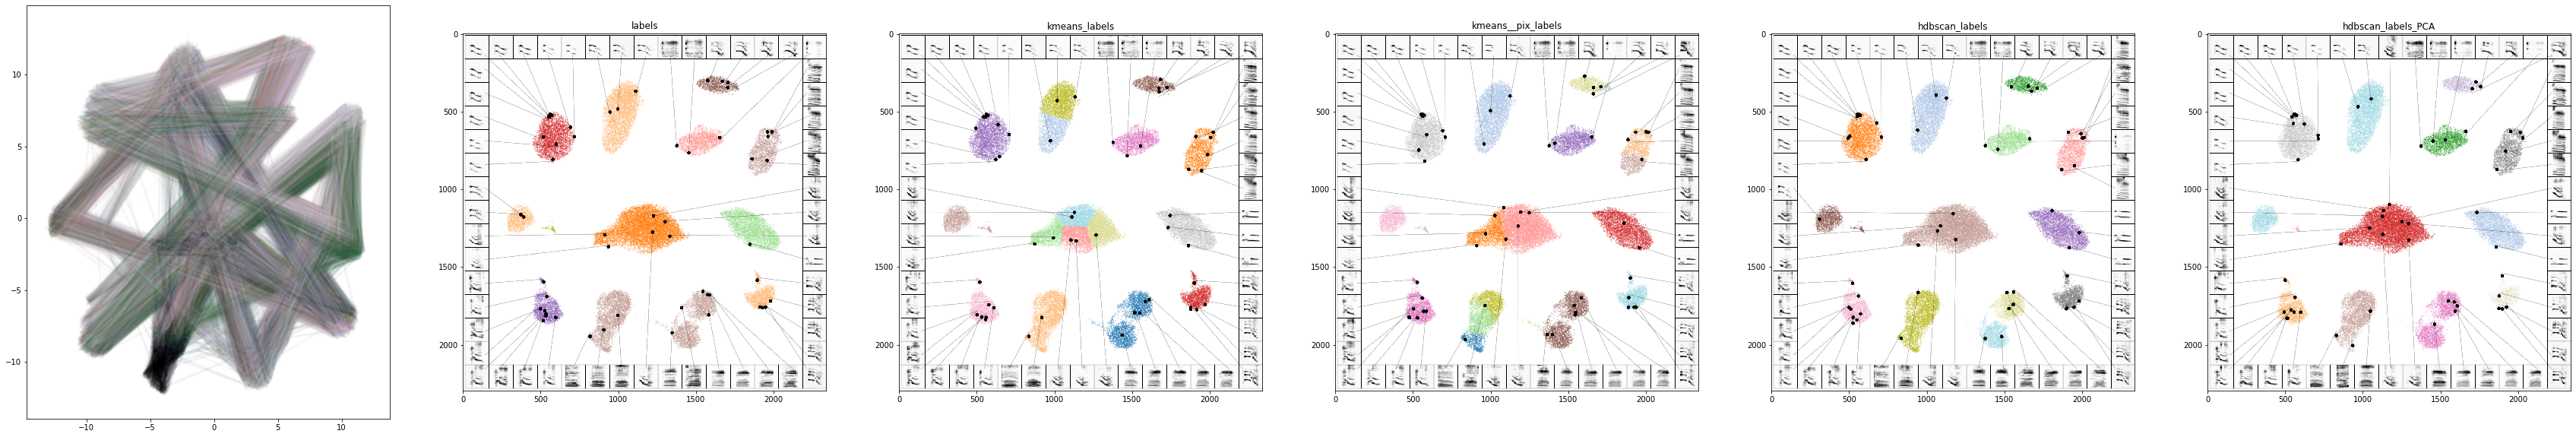

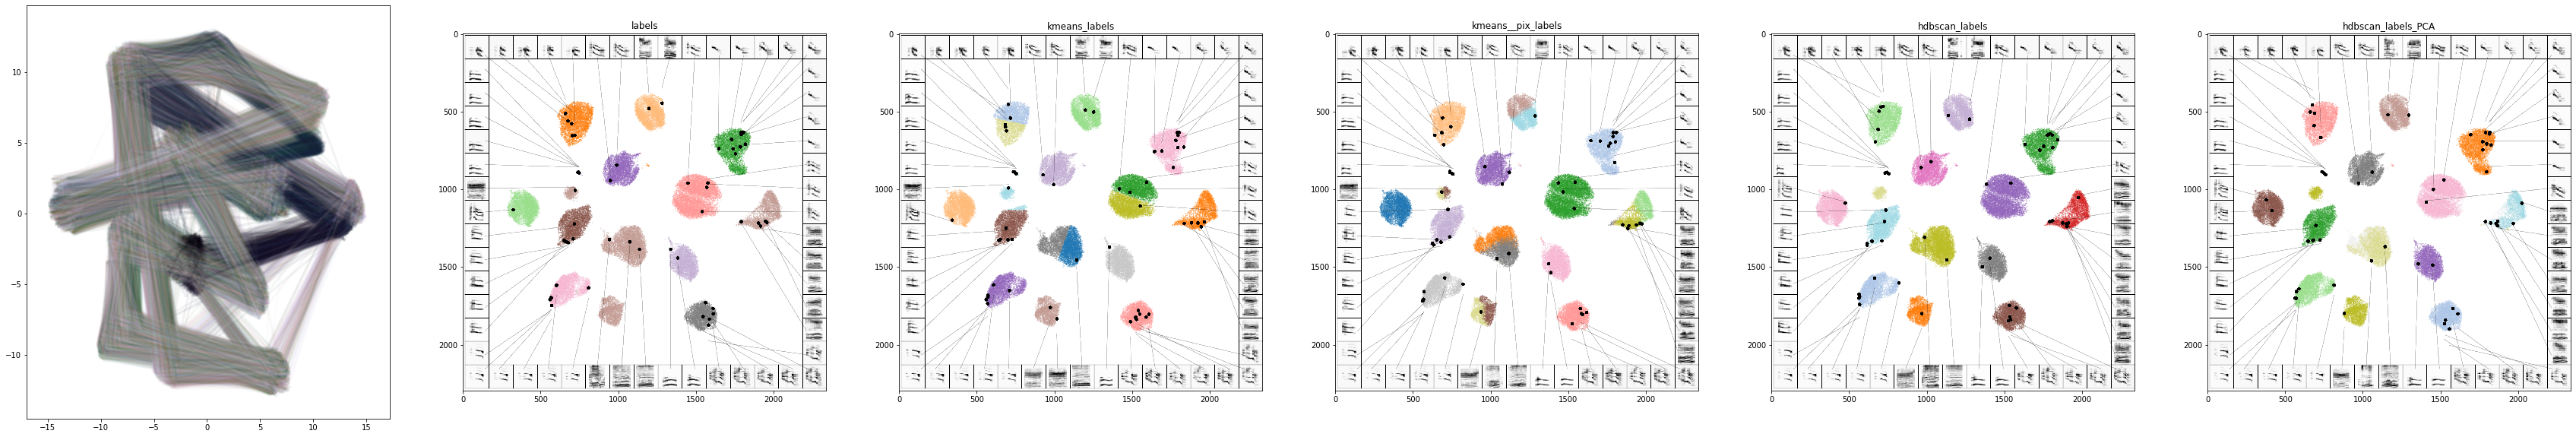

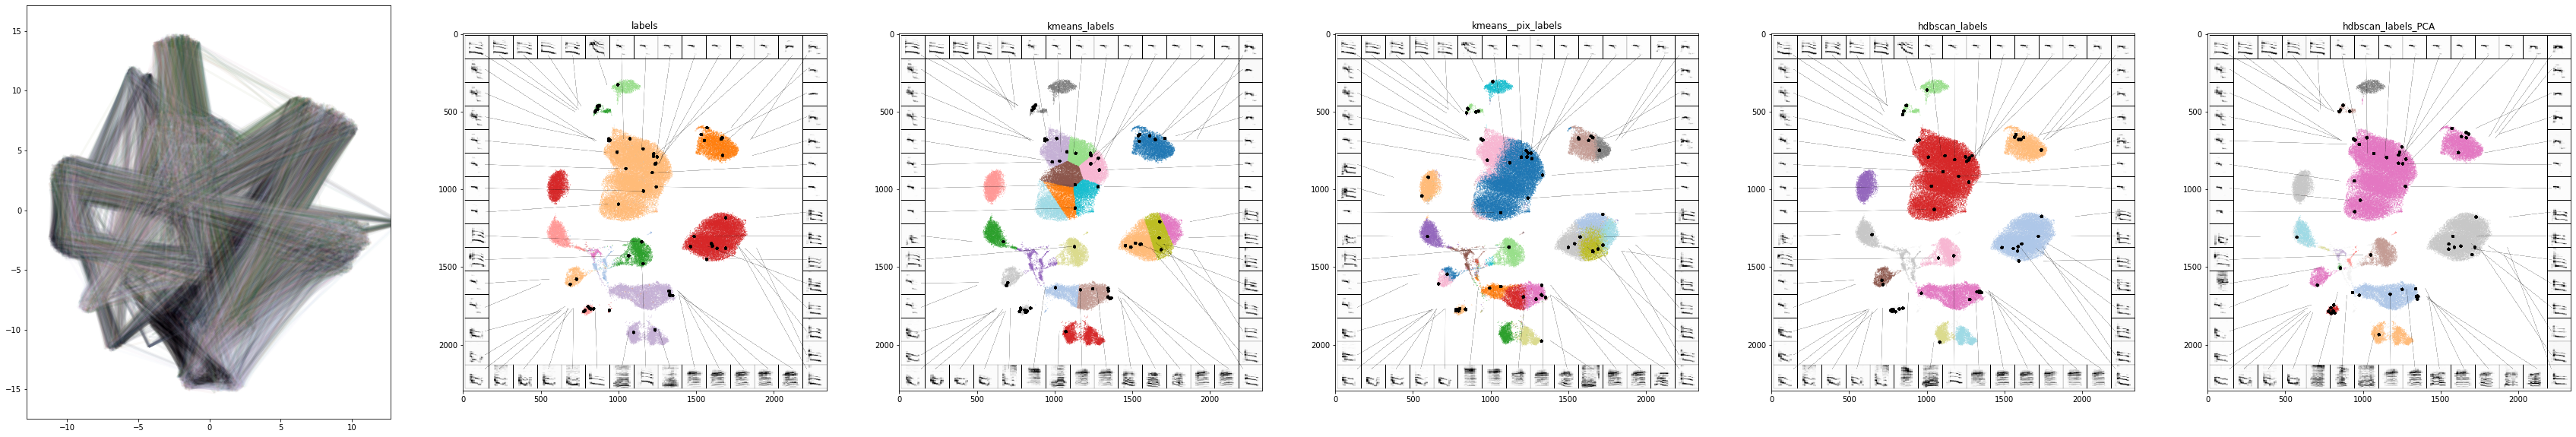

In [20]:
for indv in tqdm(indv_dfs.keys()):
    fig, axs = plt.subplots(ncols=6, figsize=(60, 10))
    draw_projection_transitions(
        projections=np.array(list(indv_dfs[indv]["umap"].values)),
        sequence_ids=indv_dfs[indv]["syllables_sequence_id"],
        sequence_pos=indv_dfs[indv]["syllables_sequence_pos"],
        ax=axs[0],
    )

    for i, lab in enumerate(
        [
            "labels",
            "kmeans_labels",
            "kmeans__pix_labels",
            "hdbscan_labels",
            "hdbscan_labels_PCA"
        ]
    ):

        scatter_spec(
            np.array(list(indv_dfs[indv]["umap"].values)),
            specs = indv_dfs[indv].spectrogram.values,
            column_size=15,
            # x_range = [-5.5,7],
            # y_range = [-10,10],
            pal_color="hls",
            color_points=False,
            enlarge_points=20,
            figsize=(10, 10),
            scatter_kwargs={
                "labels": list(indv_dfs[indv][lab].values),
                "alpha": 0.25,
                "s": 1,
                "show_legend": False,
            },
            matshow_kwargs={"cmap": plt.cm.Greys},
            line_kwargs={"lw": 1, "ls": "solid", "alpha": 0.25},
            draw_lines=True,
            ax=axs[i + 1],
        )
        axs[i + 1].set_title(lab)
    plt.show()

### save dataframes for paper

In [21]:
ensure_dir(DATA_DIR / "paper_data" / "clustering_umap" / "bengalese_finch_sober")

In [22]:
for indv in tqdm(indv_dfs.keys()):
    indv_dfs[indv].to_pickle(DATA_DIR / "paper_data" / "clustering_umap" / "bengalese_finch_sober" / (indv + ".pickle"))

In [23]:
pd.__version__

'0.25.3'

### human vs algorithmic labelling similarity

In [22]:
import sklearn.metrics

In [23]:
performance_df = pd.DataFrame(columns = ['indv', 'cluster', 'homogeneity', 'completeness', 'V-Measure', 'Adj. MI'])
for indv in tqdm(indv_dfs.keys()):
    for cluster in ['hdbscan_labels', 'kmeans__pix_labels', 'kmeans_labels', 'hdbscan_labels_PCA']:
        homogenaity, completeness, v_measure = sklearn.metrics.homogeneity_completeness_v_measure(
            list(indv_dfs[indv].labels), list(indv_dfs[indv][cluster].values)
        )
        ami = sklearn.metrics.adjusted_mutual_info_score(
            list(indv_dfs[indv].labels), list(indv_dfs[indv][cluster].values)
        )
        performance_df.loc[len(performance_df)] = [indv, cluster, homogenaity, completeness, v_measure, ami]

In [24]:
performance_df[:4]

indv             cluster  homogeneity  completeness  V-Measure  \
0  gr41rd51      hdbscan_labels     0.943445      0.956508   0.949932   
1  gr41rd51  kmeans__pix_labels     0.940208      0.737118   0.826368   
2  gr41rd51       kmeans_labels     0.946349      0.692199   0.799564   
3  gr41rd51  hdbscan_labels_PCA     0.874724      0.857782   0.866170   

    Adj. MI  
0  0.949882  
1  0.826065  
2  0.799214  
3  0.866007

In [25]:
summary = performance_df.groupby(['cluster']).describe()

In [26]:
import seaborn as sns
sns.set_context("paper", font_scale=2)

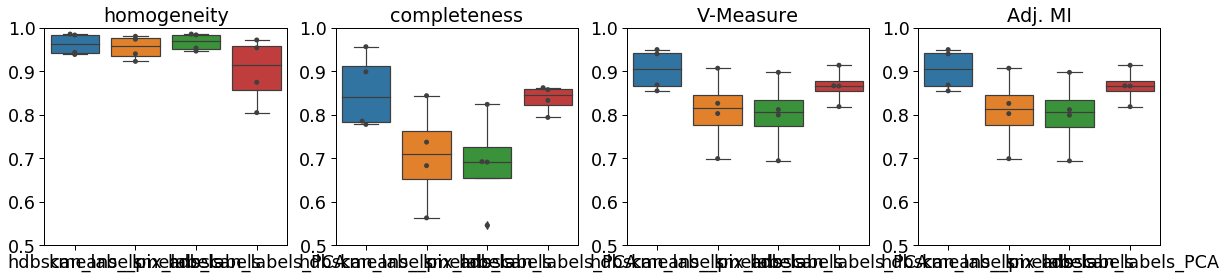

In [27]:
fig, axs = plt.subplots(ncols = 4, figsize=(20,4))

for ci, column in enumerate(["homogeneity", "completeness", "V-Measure", "Adj. MI"]):
    sns.boxplot(x="cluster", y=column, data =performance_df, ax = axs[ci])
    sns.swarmplot(x="cluster", y=column, data =performance_df, ax = axs[ci], color=".25")
    axs[ci].set_ylim([0.5,1])
    #axs[ci].set_xticklabels(['HDBSCAN/UMAP', 'KMeans', 'KMeans/UMAP'], rotation=45, ha='right')
    axs[ci].set_xlabel('')
    axs[ci].set_ylabel('')
    axs[ci].set_title(column)



In [30]:
cats = ["homogeneity", "completeness", "V-Measure", "Adj. MI"]
results_latex_df = pd.DataFrame(
    columns=["Homogeneity", "Completeness", "V-Measure", "Adjusted MI"]
)

labs = [['hdbscan_labels', 'HDBSCAN/UMAP'], ['kmeans__pix_labels', 'KMeans'], ['kmeans_labels', 'KMeans/UMAP'], ["hdbscan_labels_PCA", " HDBSCAN/PCA"]]

for lab, name in labs:
    results_latex_df.loc[name] = [
        str(
            round(np.mean(performance_df[performance_df.cluster == lab][i].values),3)
        ).zfill(3)
        + "\u00B1"
        + str(
            round(np.std(performance_df[performance_df.cluster == lab][i].values),3)
        ).zfill(3)
        for i in cats
    ]
results_latex_df = pd.concat([results_latex_df], keys=[''], names=['Nicholson et al., ()'])
results_latex_df

Homogeneity Completeness    V-Measure  \
Nicholson et al., ()                                                       
                     HDBSCAN/UMAP  0.963±0.022  0.855±0.076  0.903±0.042   
                     KMeans        0.954±0.024  0.707±0.101  0.809±0.074   
                     KMeans/UMAP   0.967±0.018  0.688±0.098  0.801±0.072   
                      HDBSCAN/PCA  0.901±0.067  0.837±0.027  0.866±0.034   

                                   Adjusted MI  
Nicholson et al., ()                            
                     HDBSCAN/UMAP  0.903±0.042  
                     KMeans        0.809±0.074  
                     KMeans/UMAP   0.801±0.072  
                      HDBSCAN/PCA  0.866±0.034

In [31]:
results_string = results_latex_df.to_latex(bold_rows=True, escape=False)\
      .replace('>', '$>$')\
.replace('±', '$\pm$')\
      .replace('<', '$<$')\
      .replace('superlabel', '')\
     .replace('\n\\textbf', '\n\midrule\n\\textbf')
print(results_string)


\begin{tabular}{llllll}
\toprule
                     &              &  Homogeneity & Completeness &    V-Measure &  Adjusted MI \\
\midrule
\textbf{Nicholson et al., ()} & {} &              &              &              &              \\
\midrule
                     & \textbf{HDBSCAN/UMAP} &  0.963$\pm$0.022 &  0.855$\pm$0.076 &  0.903$\pm$0.042 &  0.903$\pm$0.042 \\
                     & \textbf{KMeans} &  0.954$\pm$0.024 &  0.707$\pm$0.101 &  0.809$\pm$0.074 &  0.809$\pm$0.074 \\
                     & \textbf{KMeans/UMAP} &  0.967$\pm$0.018 &  0.688$\pm$0.098 &  0.801$\pm$0.072 &  0.801$\pm$0.072 \\
                     & \textbf{ HDBSCAN/PCA} &  0.901$\pm$0.067 &  0.837$\pm$0.027 &  0.866$\pm$0.034 &  0.866$\pm$0.034 \\
\bottomrule
\end{tabular}

